In [1]:
# Spectacle
import spectacle
from spectacle.core.spectra import Spectrum1D
from spectacle.modeling.models import Absorption1D
from spectacle.core.lines import Line
from spectacle.modeling.fitting import LevMarFitter, LevMarLSQFitter, DynamicLevMarFitter

# Misty
import os, sys
sys.path.insert(0, "/Users/nearl/projects/enzo_specs/")
import MISTY

# yt/enzo
import trident
import yt

# general
import numpy as np
import astropy as at
import matplotlib.pyplot as plt

%matplotlib notebook
print(np.__version__, at.__version__)

INFO:root:Added misty to custom loaders.
INFO:root:Added my-format to custom loaders.


1.12.1 1.3.3


# Trident setup

In [2]:
# Load trident ray data using yt
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp022.9_ang5.32_tri.h5")
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp020.0_ang0.00tri.h5")
tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp046.4_ang3.23_tri.h5")
# tri_ray = yt.load("/Users/nearl/Downloads/RD0042_ray_z_imp063.8_ang6.07_tri.h5")

# Parse the start/end of ray
ray_start = tri_ray.light_ray_solution[0]['start']
ray_end = tri_ray.light_ray_solution[0]['end']

# Get line information for the line we want
line_name = "Si II 1260"
ldb = trident.LineDatabase('lines.txt')
line_out = ldb.parse_subset(line_name)
line_out = line_out[0]
ar = tri_ray.all_data()

print(line_name, line_out)

# Parse spectrum information from ray
lambda_rest = line_out.wavelength
lambda_min = lambda_rest * (1+min(ar['redshift_eff'])) - 0
lambda_max = lambda_rest * (1+max(ar['redshift_eff'])) + 0
sg = trident.SpectrumGenerator(lambda_min=lambda_min.value, lambda_max=lambda_max.value, dlambda=0.0001)
sg.make_spectrum(tri_ray, lines=line_out.name)

yt : [INFO     ] 2017-06-01 12:11:36,341 Parameters: current_time              = 4.343065399597899e+17 s
yt : [INFO     ] 2017-06-01 12:11:36,342 Parameters: domain_dimensions         = [2 2 2]
yt : [INFO     ] 2017-06-01 12:11:36,344 Parameters: domain_left_edge          = [ 0.  0.  0.] cm
yt : [INFO     ] 2017-06-01 12:11:36,345 Parameters: domain_right_edge         = [  4.43982386e+26   4.43982386e+26   4.43982386e+26] cm
yt : [INFO     ] 2017-06-01 12:11:36,346 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2017-06-01 12:11:36,347 Parameters: current_redshift          = 4.4408920985e-16
yt : [INFO     ] 2017-06-01 12:11:36,347 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2017-06-01 12:11:36,348 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2017-06-01 12:11:36,349 Parameters: hubble_constant           = 0.695
yt : [INFO     ] 2017-06-01 12:11:36,417 Allocating for 1.290e+02 particles (index particle type 'all')


Si II 1260 Si II 1260


yt : [INFO     ] 2017-06-01 12:11:36,421 Identified 1.450e+02 octs
yt : [INFO     ] 2017-06-01 12:11:36,678 Setting instrument to Custom
yt : [INFO     ] 2017-06-01 12:11:36,683 Creating Si_p1_number_density from ray's density, temperature, metallicity.
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trident/ion_balance.py:378: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  force_override=force_override)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trident/ion_balance.py:388: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  force_override=force_override)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trident/ion_balance.py:410: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  particle_type=particle_type, force_override=force_override)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/trid

# Spectacle setup

In [3]:
# Create Spectrum1D from trident information
disp = np.array(list(sg.lambda_field))
flux = np.array(list(sg.flux_field))
spectrum = Spectrum1D(flux, dispersion=disp)

<IPython.core.display.Javascript object>


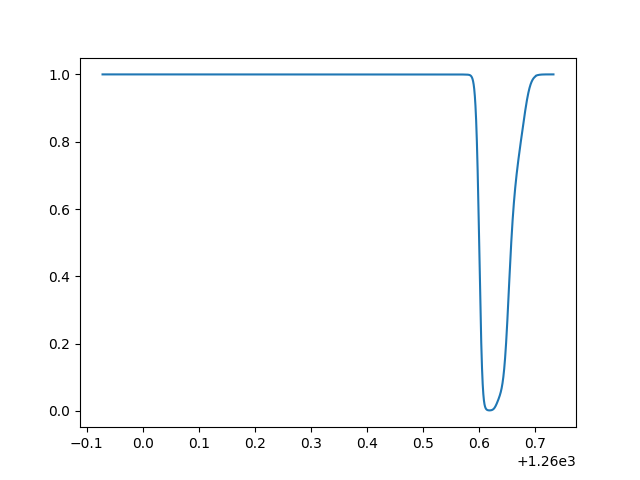

In [4]:
# Plot the trident spectrum
f, ax1 = plt.subplots()

ax1.plot(disp, flux)

In [5]:
# Create Line1D from trident line information
sg_line = sg.line_list[0]

# This process will find lines in the trident spectrum
# and assign the values set in the `defaults` dict to
# the new lines found.
lines = spectrum.find_lines(threshold=0.02/max(1-spectrum.data),
                            min_dist=10,
                            smooth=False,
                            interpolate=True,
                            defaults=dict(
                                lambda_0=sg_line['wavelength'].value,
                                f_value=sg_line['f_value'],
                                gamma=sg_line['gamma'],
                                fixed={
                                    'lambda_0': True,
                                    'delta_v': True,
                                    'delta_lambda': False}
                           ))

# Create absorption Spectrum1D from line information
spec_mod = Absorption1D(lines=lines)

# Create a Spectrum1D object from the Absorption1D model
gen_spec = spec_mod(spectrum.dispersion)

INFO:root:Found 1 lines.
INFO:root:Found FeII1261 (1260.533) at 1260.6181316654483. Strict is False.
INFO:root:There are 1 lines in the model.


<IPython.core.display.Javascript object>


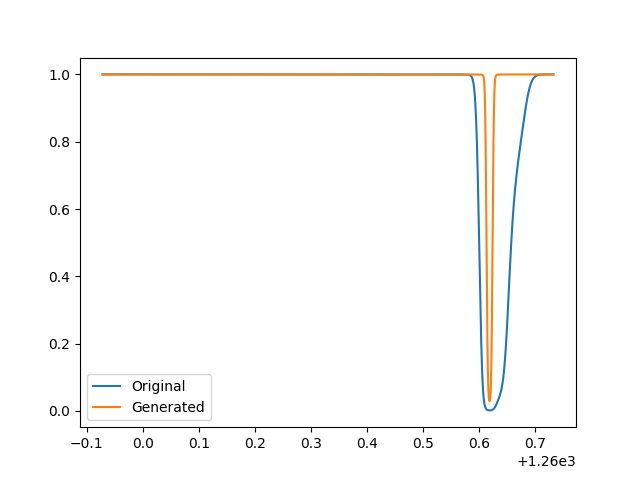

In [6]:
# Plot the generated absorption spectrum
f, ax = plt.subplots()

ax.plot(spectrum.dispersion, spectrum.data, label="Original")
ax.plot(spectrum.dispersion, gen_spec.data, label="Generated")
# ax.set_xlim(1259.63, 1260.78)

plt.legend(loc=0)

In [7]:
# Now fit the generated Spectrum1D object to the ray spectrum data

# Create a fitter
fitter = DynamicLevMarFitter()

fit_spec_mod = fitter(spec_mod, spectrum.dispersion, spectrum.data, 
                      maxiter=1000, initialize=False)

# Get the results of the fit
fit_spec = fit_spec_mod(spectrum.dispersion)

INFO:root:Fit did not improve by removing line:
	Chi squared: 109.71312085424128 -> 43213.24822955294.
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/astropy/units/quantity.py:957: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__truediv__(other)
/Users/nearl/anaconda3/envs/spec_env/lib/python3.6/site-packages/astropy/units/quantity.py:974: RuntimeWarning: divide by zero encountered in true_divide
  return super(Quantity, self).__rtruediv__(other)
/Users/nearl/projects/spectacle/spectacle/core/profiles.py:90: RuntimeWarning: invalid value encountered in multiply
  return special.wofz(x + 1j * y).real
/Users/nearl/projects/spectacle/spectacle/core/spectra.py:119: RuntimeWarning: invalid value encountered in less
  data[data < 0.0] = 0.0
INFO:root:Fit improved with addition of line at 1260.6056306232888:
	Chi squared: 109.71312085424128 -> 11.80311660397035.
INFO:root:Fit improved with addition of line at 1260.6423336830692:
	Ch

<class 'abc.Absorption1D'>
Name: Absorption1D (CompoundModel14)
Inputs: ('x',)
Outputs: ('y',)
Fittable parameters: ('slope_0', 'intercept_0', 'lambda_0_1', 'f_value_1', 'gamma_1', 'v_doppler_1', 'column_density_1', 'delta_v_1', 'delta_lambda_1', 'lambda_0_2', 'f_value_2', 'gamma_2', 'v_doppler_2', 'column_density_2', 'delta_v_2', 'delta_lambda_2', 'lambda_0_3', 'f_value_3', 'gamma_3', 'v_doppler_3', 'column_density_3', 'delta_v_3', 'delta_lambda_3', 'lambda_0_4', 'f_value_4', 'gamma_4', 'v_doppler_4', 'column_density_4', 'delta_v_4', 'delta_lambda_4', 'lambda_0_5', 'f_value_5', 'gamma_5', 'v_doppler_5', 'column_density_5', 'delta_v_5', 'delta_lambda_5')
Expression: [0] + [1] + [2] + [3] + [4] + [5]
Components: 
    [0]: <Linear1D(slope=-0.0007934945359997103, intercept=2.0)>

    [1]: <Line(lambda_0=1260.422, f_value=0.188, gamma=403000000.0, v_doppler=472491.81491038675, column_density=12.670584554871297, delta_v=0.0, delta_lambda=0.23835135831038734, name='FeII1261')>

    [2]: <Lin

<IPython.core.display.Javascript object>


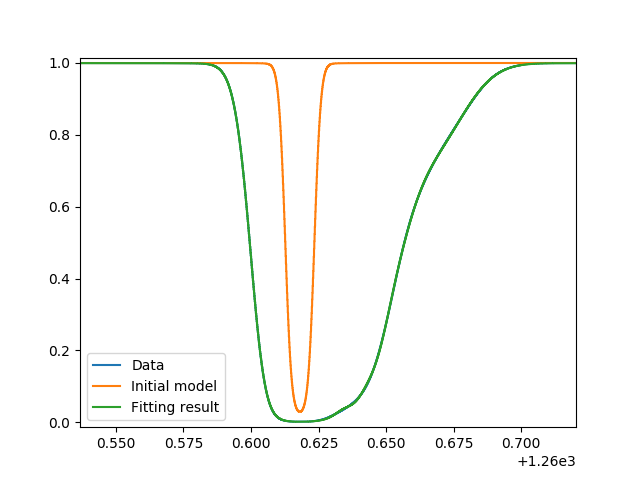

In [8]:
print(type(fit_spec_mod))

# Plot the stacked results
f, (ax1) = plt.subplots()

ax1.step(spectrum.dispersion, spectrum.data, label="Data")
ax1.step(gen_spec.dispersion, gen_spec.data, label="Initial model")
ax1.step(fit_spec.dispersion, fit_spec.data, label="Fitting result")
# ax1.set_xlim(1259.7, 1260.26)

plt.legend(loc=0)